# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Idea" data-toc-modified-id="Idea-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Idea</a></div><div class="lev2 toc-item"><a href="#Inverse-Model" data-toc-modified-id="Inverse-Model-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Inverse Model</a></div><div class="lev1 toc-item"><a href="#The-game" data-toc-modified-id="The-game-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The game</a></div><div class="lev2 toc-item"><a href="#The-environment" data-toc-modified-id="The-environment-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The environment</a></div><div class="lev1 toc-item"><a href="#Estamos-corretamente-sampleando-da-distribuição" data-toc-modified-id="Estamos-corretamente-sampleando-da-distribuição-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Estamos corretamente sampleando da distribuição</a></div><div class="lev1 toc-item"><a href="#Model-inversion" data-toc-modified-id="Model-inversion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model inversion</a></div>

# Idea

## Inverse Model

Bayesian rat. 
- Parameters
    - Learning Rate
    - Weber Fixed
    - Discounting
    

# The game

## The environment

In [1]:
import os
os.chdir('../../')

In [2]:
from spikelearn.visuals.visuals import singleRatBehaviorPlot
from spikelearn.data.utils import reyes_cp
from spikelearn.data import io, select, SHORTCUTS

In [3]:
from itertools import count, product
import scipy.stats as st
import numpy as np
import pandas as pd
import time
import gc
from tqdm import tqdm

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [5]:
sns.set_style('darkgrid')
plt.style.use('dark_background')
mpl.rc("figure", figsize=(10,6))
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.facecolor'] = (1,1,1,0)
mpl.rcParams['figure.facecolor'] = (1,1,1,0)
sns.set_palette('deep', color_codes=True)

- TODO 
    - Ajustar distribuições para que fiquem todas .sum()\*dt = 1 (normalizar)
    - Testar discounting na escolha da ação
    - Verificar motivo dos picos distantes
    - Testar exponencial
        - No update -> ao invés do *reward
        - Na resposta 
        

- Futuro
    - Pegar prior do autoshape
    - Muscimol & discounting

In [6]:
class DRRD():
    """
    
    The Rat instance input in the play function must implement:
    - act() returning a float
    - get_reward()
    - is_tired_ , a boolean attribute.
    """
    def __init__(self, criterion, remember=True):
        # Time in seconds
        self.criterion = criterion
        if remember:
            self.history = pd.DataFrame(columns=['action', 'reward', 'criterion'])
        self.has_memory = remember
        
    def _reward(self, time):
        if time > self.criterion:
            return True
        else:
            return False
        
    def _store(self, action, reward):
        trial_data = pd.DataFrame({'action': action,
                                   'reward': reward,
                                   'criterion': self.criterion},
                                    index = pd.Index([self.trial], name='trial'))
        self.history = self.history.append(trial_data)
        
    def _reward_and_remember(self, action, rat):
        reward = self._reward(action)
        rat.get_reward(reward)
        
        if self.has_memory: self._store(action, reward)
        
        
    def play(self, rat, max_rounds=None):
        if max_rounds is None:
            playtime = count()
        else:
            playtime = range(max_rounds)
            
        for self.trial in playtime:
            action = rat.act()
            self._reward_and_remember(action, rat)
            if rat.is_tired_: break
                

class BayesianRat():
    """
    
    Attributes
    ----------
    
    model_logL
    """
    def __init__(self, learning_rate=.01, discounting=0, weber_ratio=.15, 
                    likelihood_dist='normal', range=(0,6), dt=1e-3, 
                    prior='lognormal' , responses=None, rule='like',
                    remember = True):
        
        self.weber_ratio = weber_ratio
        self.discounting = discounting
        self.learning_rate = learning_rate
        self.update_rule = rule
        self.dt = dt
        
        
        self.sup = np.arange(range[0], range[1], dt)
        self.prior_ = self._make_prior(prior)
        self.cdf_ = self.prior_.cumsum()
        if remember:
            self.prior_history = [self.prior_]
            self.likely_history = []
        self.has_memory = remember
        
        self.likelihood_dist_ = self._make_lh(prior)

        self.last_response_ = None
        self.responses = list(responses) if responses is not None else None
        
        self.is_tired_ = False
        
        # Stores the likelihood of actions taken given probabilities
        self.model_logL_ = 0
    
    # Meta function
    def _update_model_likelihood(self):
        move_probability = self.prior_[np.abs(self.sup - self.last_response_).argmin()]
        self.model_logL_ += np.log(move_probability)
    
    # Initialization functions
    def _make_prior(self, prior):
        if prior == 'lognormal':
            return st.lognorm(scale=1, s=1).pdf(self.sup)*self.dt
        elif isinstance(prior, np.array):
            assert len(prior) == len(self.sup)
            assert prior.sum()== 1/dt
            return prior
    
    def _make_lh(self, likelihood_dist):
        if likelihood_dist == 'lognormal':
            return lambda t: st.lognorm(scale=t, s=self.weber_ratio).pdf(self.sup)
        elif likelihood_dist == 'normal':
            return lambda t: st.norm(loc=t, scale=self.weber_ratio*t).pdf(self.sup)
    
    # Internal functions
    def _perceived_time(self, time):
        lkl = self.likelihood_dist_(time)
        return lkl/lkl.sum()
            
    def _update_prior(self, reward_value):
        likely_time = self._perceived_time(self.last_response_)
        
        
        if self.update_rule == 'like':
            update = likely_time
        elif self.update_rule == 'post':
            update = self.prior_ * likely_time
            update /= update.sum()
        
        lr = self.learning_rate * reward_value
        
        self.prior_ = (self.prior_ + update*lr)/(1+lr)
        self.prior_ /= self.prior_.sum()
        self.cdf_ = self.prior_.cumsum()
        
        if self.has_memory: 
            self.likely_history.append(likely_time)
            self.prior_history.append(self.prior_)
    
    def _sample_action(self):
        return self.sup[np.abs(self.cdf_ - np.random.rand()).argmin()]

    def _act_based_on_data(self):
        if len(self.responses) == 1: # Last response
            self.is_tired_ = True
        return self.responses.pop(0)
        
    # Behavior
    def act(self):
        if self.responses is not None:
            self.last_response_ = self._act_based_on_data()
        else:
            self.last_response_ = self._sample_action()
        
        self._update_model_likelihood()
        return self.last_response_

        
    def get_reward(self, reward):
        if reward:
            self._update_prior(np.exp(- self.discounting * self.last_response_))
       

---

In [8]:
bayes = BayesianRat(discounting=0, learning_rate=.02, dt=0.001, rule='post', range=(0,15))

task = DRRD(1.5)


%time task.play(bayes, 2000)

CPU times: user 7.94 s, sys: 228 ms, total: 8.17 s
Wall time: 8.18 s


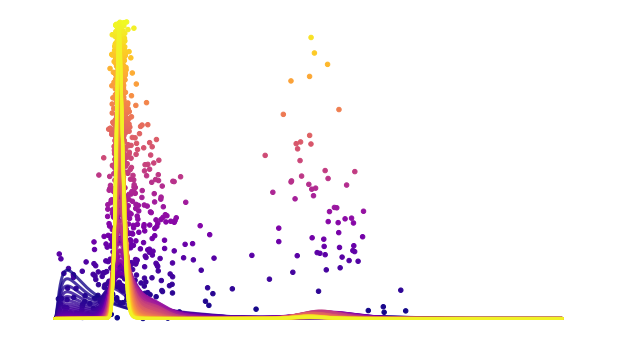

In [9]:
N, k = 80, 10


prior_n = task.history.reward.cumsum()
trials_to_plot = prior_n < N*k
plt.scatter(task.history.action[trials_to_plot],trials_to_plot[trials_to_plot].index, 
                cmap='plasma', c=prior_n[trials_to_plot], s=20)
plt.gca().grid()

plt.twinx()

c = sns.color_palette('plasma', N)
for i in range(N):
    plt.plot(bayes.sup, bayes.prior_history[k*i], color=c[i], alpha=.8)

plt.gca().grid()

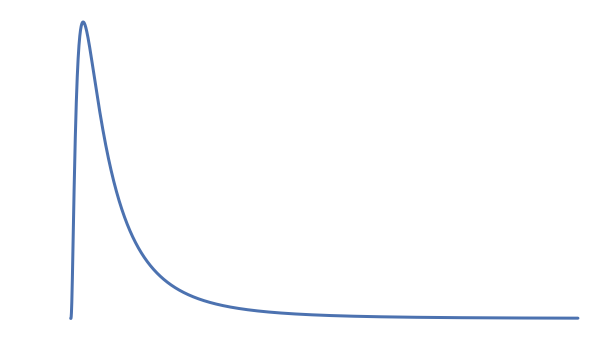

In [63]:
plt.plot(st.lognorm(scale=1, s=1).pdf(naive.sup)*naive.dt)

In [62]:
naive = BayesianRat(range=(0,15))

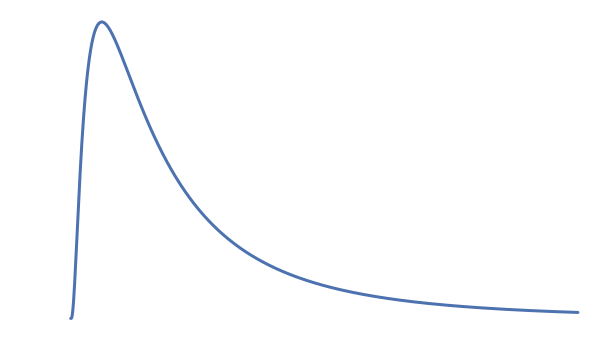

In [42]:
plt.plot(naive.prior_)

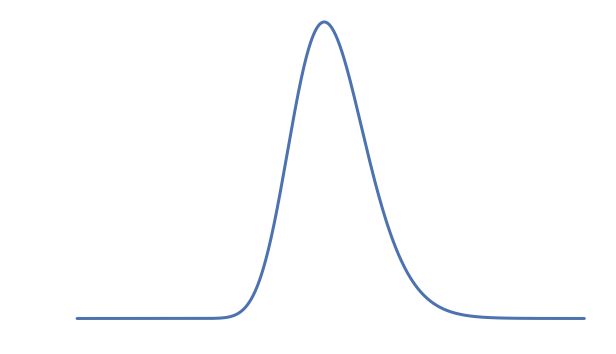

In [34]:
plt.plot(bayes.sup, bayes.likely_history[800])

In [160]:
bayes.model_logL_

-8215.4531676264451

In [18]:
N=40
for i in range(N):
    sns.distplot(behav.duration[int(i*.8):i*10+30], hist=False, color=c[i])

NameError: name 'behav' is not defined

/home/tevo/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


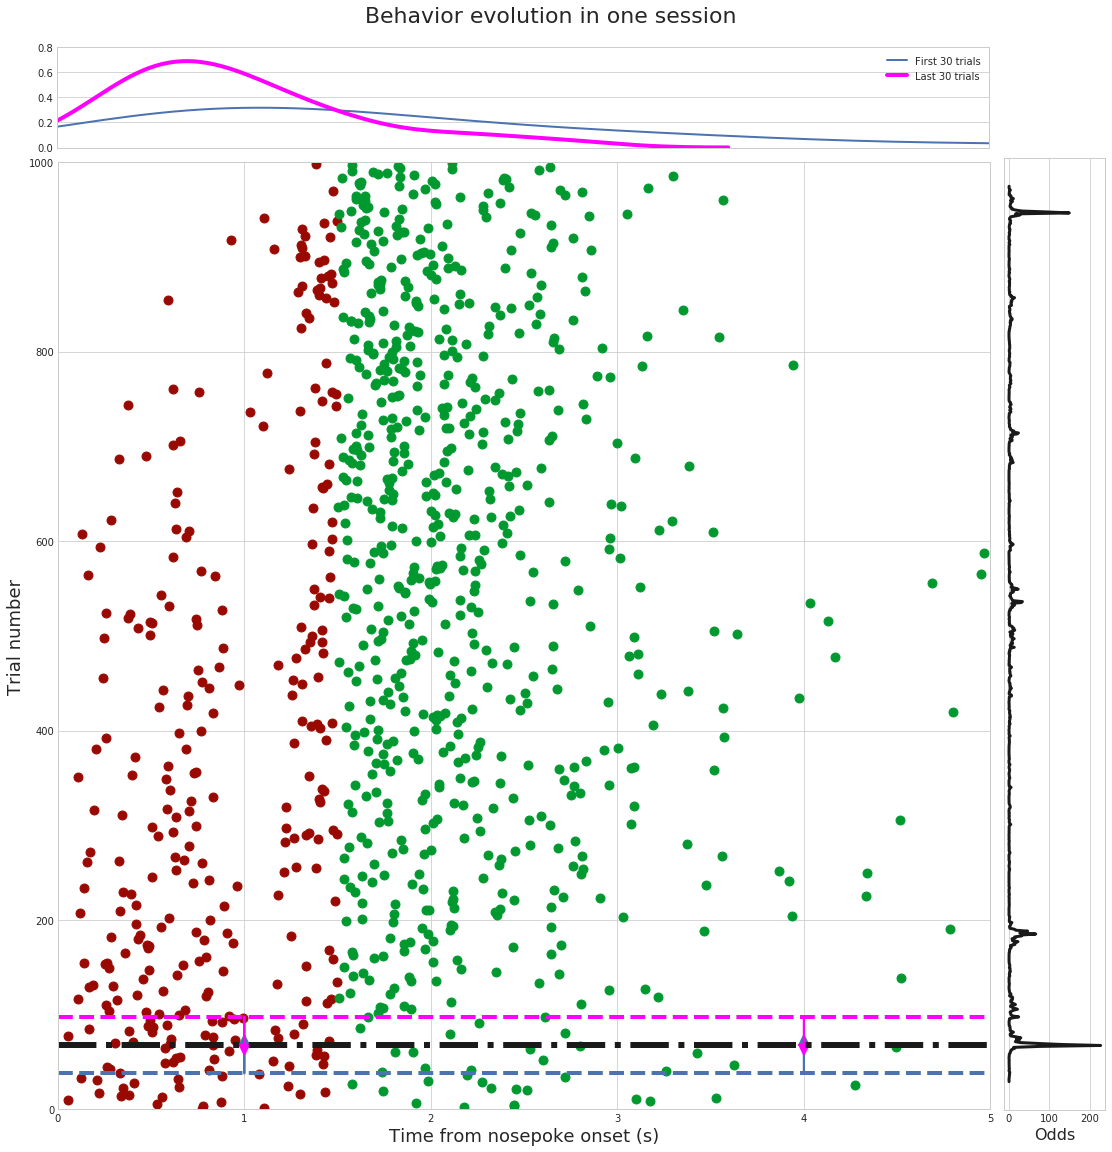

In [19]:
singleRatBehaviorPlot(np.array(task.history.action), reyes_cp(task.history.action), kde='cp', kdeN=30)

---

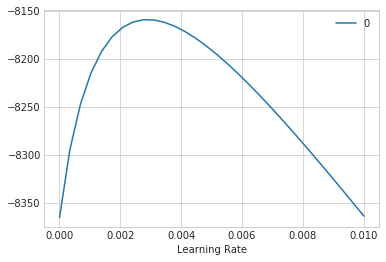

In [115]:
logL.transpose().plot()

---

# Estamos corretamente sampleando da distribuição

In [98]:
prior = st.lognorm(scale=4, s=.15).pdf(sup)

In [26]:
cdf = prior.cumsum().reshape(-1,1)
cdf /=cdf.max()

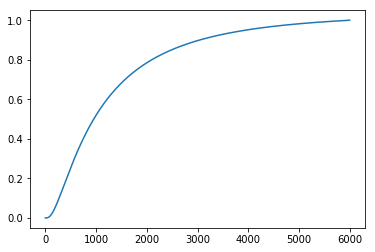

In [27]:
plt.plot(cdf)

In [44]:
N = 1000
s = sup[np.abs(cdf-np.random.random(size=(1,N))).argmin(axis=0)]

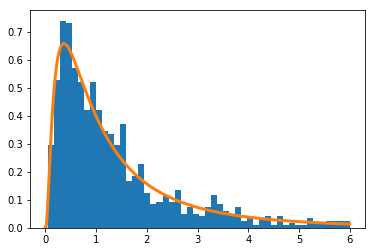

In [45]:
plt.hist(s,50, density=True);
plt.plot(sup, prior, linewidth=3)

In [47]:
s.mean()

1.3459909999999999

- Taxa média
- Bracketing

---

# Model inversion

In [156]:
def invert_model(game, model, responses, param_dict, pbar=True):
    param_names = list(param_dict.keys())
    results = pd.DataFrame(columns=param_names+['loglikelihood'])
    if pbar:
        niter = len(list(product(*tuple(param_dict.values()))))
        param_combs = tqdm(product(*tuple(param_dict.values())), total=niter)
    else:
        param_combs = product(*tuple(param_dict.values()))
    for params in param_combs:
        instance_params = dict(zip(param_names, params))
        instance = model(responses=responses,**instance_params, remember=False)
        
        cronometer = time.time()
        game.play(instance)
        
        
        instance_params.update({'loglikelihood':instance.model_logL_,
                                'time': time.time()-cronometer } )
        results = results.append(pd.DataFrame(instance_params, index=[0]))
        gc.collect()
    return results
 
def uninformed_search(responses, task, rule):
    """
    Uninformed search will consist of 3 parts:
    Learning rate search
    
    1. Order of magnitude search
        1.1. 1e-o 1e5
        1.2. best/10 to best*10
        
    2. Linear search
        - Best fit
    
    Discount search
    3. Grid
        - lr to lr*10
        - Discount 0 to 3 (linear)
    """
    # Uninformed search
    # Phase 1.1
    lrates = np.logspace(-5, 5, 10)
    param_dict = {'learning_rate' : lrates, 'rule':[rule]}
    phase11 = invert_model(task, BayesianRat, 
                   responses = responses, 
                   param_dict = param_dict, pbar=False).set_index('learning_rate')
    best_lr = phase11.loglikelihood.idxmax()
    
    
    # Phase 1.2
    lrates = np.logspace(np.log10(best_lr)-1, np.log10(best_lr)+1, 10)
    param_dict = {'learning_rate' : lrates, 'rule':[rule]}
    phase12 = invert_model(task, BayesianRat, 
                   responses = responses, 
                   param_dict = param_dict, pbar=False).set_index('learning_rate')
    best_lr = phase12.loglikelihood.idxmax()
    
    # Phase 2
    lrates = np.linspace(best_lr/10, best_lr*10, 50)
    param_dict = {'learning_rate' : lrates, 'rule':[rule]}
    res_lr = invert_model(task, BayesianRat, 
                   responses = responses, 
                   param_dict = param_dict, pbar=False).set_index('learning_rate')
    best_lr = res_lr.loglikelihood.idxmax()
    
    # Phase 3
    lrates, discounts = np.linspace(best_lr, best_lr*10, 30), np.linspace(0, 3, 30)
    param_dict = {'learning_rate' : lrates, 'discounting':discounts, 'rule':[rule]}
    res_both = invert_model(task, BayesianRat, 
                   responses = responses, 
                   param_dict = param_dict, pbar=False).set_index(['learning_rate', 'discounting'])

    return phase11, phase12, res_lr, res_both


def best_fit(responses, task):
    _, _, lr_post, both_post = uninformed_search(responses, task, 'post')
    _, _, lr_like, both_like = uninformed_search(responses, task, 'like') 
    return pd.concat((lr_post, lr_like)), pd.concat((both_post, both_like))

In [157]:
for label in SHORTCUTS['groups']['DRRD']:
    print(label)
    responses = select(io.load(label, 'behav_stats'), is_tired=False).duration.values
    task = DRRD(1.5, False)
    best_lr, best_both = best_fit(responses, task)
    if not os.path.exists('data/results/bayesian_learning'):
        os.makedirs('data/results/bayesian_learning')
    pickle.dump(best_lr, open('data/results/bayesian_learning/lr%s.pickle'%label, 'wb'))
    pickle.dump(best_both, open('data/results/bayesian_learning/both%s.pickle'%label, 'wb'))

KeyboardInterrupt: 